# Reactor Kinetics Example 

Jialu Wang (jwang44@nd.edu) and Alex Dowling (adowling@nd.edu)

University of Notre Dame

This notebook conducts design of experiments for a reactor kinetics experiment with the Pyomo.DOE.
    

## Step 0: Import Pyomo and Pyomo.DOE module

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import fim_doe as doe
import pyomo.common.unittest as unittest

In [2]:
## check if ipopt available 

ipopt_available = pyo.SolverFactory('ipopt').available()

if not (ipopt_available):
    raise RuntimeError('Pyomo.DOE unit tests require IPOPT')

## Step 1: Import Reaction Example Mathematical Model

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$.

$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$

Our ultimate goal is to design a large-scale continous reactor that maximizes the production of $B$. This general sequential reactions problem is widely applicable to CO$_2$ capture and industry more broadly (petrochemicals, pharmasuticals, etc.).

The rate laws for these two chemical reactions are:

$r_A = -k_1 C_A$

$r_B = k_1 C_A - k_2 C_B$

$r_C = k_2 C_B$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$k_1 = A_1 \exp{\frac{-E_1}{R T}}$

$k_2 = A_2 \exp{\frac{-E_2}{R T}}$

$A_1, A_2, E_1$, and $E_2$ are fitted model parameters. $R$ is the ideal-gas constant and $T$ is absolute temperature.

Using the **CCSI$^2$ toolset**, we would like to perform **uncertainty quantification** and **design of experiments** on a small-scale **batch reactor** to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch reactor

The concenration in a batch reactor evolve with time per the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A - k_2 C_B $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B $$

This is a linear system of differential equations. Assuming the feed is only species $A$, i.e., 

$$C_A(t=0) = C_{A0} \quad C_B(t=0) = 0 \quad C_C(t=0) = 0$$

When the temperature is constant, it leads to the following analytic solution:

$$C_A(t) = C_{A,0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A,0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A,0} - \frac{k_2}{k_2 - k_1} C_{A,0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A,0} = C_{A,0} - C_{A}(t) - C_{B}(t)$$

In [3]:
# The model is implemented in reactor_kinetics.py 
from example.reactor_kinetics import create_model, disc_for_measure

## Step 2: Define inputs

In [4]:
# Create model function
createmod = create_model

# discretization by Pyomo.DAE
disc = disc_for_measure

# Control time set [h]
t_control = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
    
# Measurement time points [h]
t_measure = [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]

# design variable and its control time set
dv_pass = {'CA0': [0],'T': t_control}
    
# Create measurement object
measure_pass = {'C':{'CA': t_measure, 'CB': t_measure, 'CC': t_measure}}
measure_class =  doe.Measurements(measure_pass)

# Define parameter nominal value 
parameter_dict = {'A1': 84.79085853498033, 'A2': 371.71773413976416, 'E1': 7.777032028026428, 'E2': 15.047135137500822}

In [5]:
def generate_exp(t_set, CA0, T):  
    """Generate experiments. 
    t_set: time control set for T.
    CA0: CA0 value
    T: A list of T 
    """
    assert(len(t_set)==len(T)), 'T should have the same length as t_set'
    
    T_con_initial = {}
    for t, tim in enumerate(t_set):
        T_con_initial[tim] = T[t]
        
    dv_dict_overall = {'CA0': {0: CA0},'T': T_con_initial}
    return dv_dict_overall

In [6]:
# empty prior
prior_pass = np.zeros((4,4))

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))
print('Eigenvalue of the prior experiments FIM:', np.linalg.eigvals(prior_pass))

The prior information FIM: [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
Prior Det: 0.0
Eigenvalue of the prior experiments FIM: [0. 0. 0. 0.]


## Method: Compute FIM 

This method computes an MBDoE optimization problem with no Degree of Freedom.

In [7]:
# choose from 'sequential_finite', 'direct_kaug'
# 'sequential_sipopt', 'sequential_kaug' is also available
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]
    

# Define experiments
exp1 = generate_exp(t_control, 5, [570, 300, 300, 300, 300, 300, 300, 300, 300])

In [8]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)


result = doe_object.compute_FIM(exp1, mode=sensi_opt, FIM_store_name = 'dynamic.csv', 
                                store_output = 'store_output', read_output=None,
                                scale_nominal_param_value=True,
                                formula='central')


result.calculate_FIM(doe_object.design_values)


Sensitivity information is scaled by its corresponding parameter nominal value.
After practice: {'C_index_CA': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CB': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1], 'C_index_CC': [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]}
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt

In [9]:
print('======Result summary======')
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(result.trace))
print('D-optimality:', np.log10(result.det))
print('E-optimality:', np.log10(result.min_eig))
print('Modified E-optimality:', np.log10(result.cond))

======Result summary======
Four design criteria log10() value:
A-optimality: 2.7885870986653556
D-optimality: 2.82184091661587
E-optimality: -1.0123469424442408
Modified E-optimality: 3.781403429910948


## Method: Optimization
Gradient-based optimization with IPOPT with .optimize_doe()

This function solves twice: It solves the square version of the MBDoE problem first, and then unfixes the design variables as degree of freedom and solves again. In this way the optimization problem can be well initialized. 

In [13]:
exp1 = generate_exp(t_control, 3, [500, 300, 300, 300, 300, 300, 300, 300, 300])

# add a prior information (scaled FIM with T=500 and T=300 experiments)
prior = np.asarray([[  28.67892806 ,   5.41249739 , -81.73674601 , -24.02377324],
 [   5.41249739 ,  26.40935036 , -12.41816477 , -139.23992532],
 [ -81.73674601 , -12.41816477 , 240.46276004 ,  58.76422806],
 [ -24.02377324 , -139.23992532 ,  58.76422806 , 767.25584508]])



In [14]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior, discretize_model=disc, args=[True])

square_result, optimize_result= doe_object.optimize_doe(exp1, if_optimize=True, if_Cholesky=True, 
                                                         scale_nominal_param_value=True, objective_option='det', 
                                                         L_initial=np.linalg.cholesky(prior))

Sensitivity information is scaled by its corresponding parameter nominal value.
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    conta

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 -3.5921203e+01 2.27e+05 2.07e+10  -1.0 6.60e+03   1.0 2.37e-04 2.30e-02f  2
  21 -3.5648726e+01 2.27e+05 2.06e+10  -1.0 2.30e+04   1.4 2.15e-04 9.14e-04h  3
  22 -3.5630047e+01 2.25e+05 2.05e+10  -1.0 1.66e+03   1.9 2.49e-03 8.56e-03h  1
  23 -3.5627707e+01 2.25e+05 2.05e+10  -1.0 2.48e+03   1.4 1.80e-01 6.81e-05h  1
  24r-3.5627707e+01 2.25e+05 1.00e+03   5.4 0.00e+00   1.8 0.00e+00 4.81e-07R  5
  25r-3.5529679e+01 2.19e+05 2.19e+04   5.4 1.59e+08    -  1.42e-07 1.64e-04f  1
  26 -3.4956471e+01 1.77e+05 5.85e+02  -1.0 3.59e+05    -  8.04e-03 2.18e-01h  1
  27 -3.0395664e+01 1.98e+05 1.38e+04  -1.0 5.20e+05    -  8.36e-01 8.66e-01H  1
  28 -3.0386687e+01 1.98e+05 1.29e+04  -1.0 8.15e+02   1.3 1.44e-03 3.67e-04h  1
  29 -3.0375576e+01 1.98e+05 1.90e+04  -1.0 8.33e+02   0.9 1.41e-03 4.63e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 -3.0309300e+01 1.98e+05

 113  3.6490304e+01 2.70e+05 5.16e+05  -1.0 1.00e+05  -2.8 9.16e-02 1.11e-03h  1
 114  3.6587690e+01 2.70e+05 5.47e+05  -1.0 1.11e+05    -  4.90e-02 2.13e-03h  5
 115  3.6493039e+01 2.70e+05 5.49e+05  -1.0 3.51e+04  -1.5 2.30e-03 1.14e-04h  8
 116  3.6453431e+01 2.70e+05 5.49e+05  -1.0 9.23e+04  -2.0 2.43e-03 1.95e-05h 10
 117  3.6402028e+01 2.70e+05 5.49e+05  -1.0 5.33e+04  -1.6 1.02e-02 4.78e-05h  9
 118  3.6363400e+01 2.70e+05 5.49e+05  -1.0 4.70e+04  -1.1 3.25e-03 4.57e-05h  8
 119  3.6337694e+01 2.70e+05 5.50e+05  -1.0 5.98e+04  -1.6 3.26e-02 3.66e-05h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120  3.6319852e+01 2.69e+05 6.01e+05  -1.0 8.75e+04  -2.1 1.81e-02 7.56e-04h  5
 121  3.6331042e+01 2.69e+05 6.08e+05  -1.0 8.62e+04  -1.7 5.01e-02 1.95e-04h  6
 122  4.4559559e+01 2.66e+05 2.15e+07  -1.0 8.52e+04  -2.1 4.58e-02 1.50e-02h  1
 123  4.2196815e+01 2.66e+05 3.50e+07  -1.0 9.76e+04   0.1 1.72e-03 3.67e-03h  1
 124  4.0687862e+01 2.65e+05

 211 -8.8455681e+00 8.86e+05 8.79e+04  -1.0 2.77e+05    -  7.16e-02 2.21e-02h  4
 212 -9.1962660e+00 8.68e+05 8.58e+04  -1.0 2.50e+05    -  8.40e-02 2.32e-02h  4
 213 -1.1381414e+01 6.90e+05 1.35e+06  -1.0 2.37e+05    -  3.28e-01 3.10e-01H  1
 214 -1.1630382e+01 6.15e+05 1.22e+06  -1.0 4.62e+04    -  3.31e-01 9.60e-02H  1
 215 -1.1979471e+01 4.24e+05 6.97e+05  -1.0 3.67e+04    -  2.42e-01 3.85e-01h  1
 216 -1.1971217e+01 4.23e+05 6.95e+05  -1.0 2.84e+04    -  7.04e-02 3.24e-03h  1
 217 -1.1723059e+01 4.13e+05 6.79e+05  -1.0 2.20e+04    -  1.17e-02 2.29e-02h  1
 218 -1.1673036e+01 4.10e+05 6.72e+05  -1.0 4.73e+04    -  2.68e-02 8.95e-03h  1
 219 -2.3181095e+00 3.28e+05 5.16e+05  -1.0 1.47e+04    -  7.87e-01 2.12e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 -4.1819159e-01 6.48e+04 4.19e+04  -1.0 9.77e+03    -  1.75e-01 8.72e-01H  1
 221 -4.1046896e-01 5.10e+04 3.40e+04  -1.0 4.55e+04    -  3.81e-01 2.38e-01h  1
 222  6.3085150e-01 4.98e+04

 304 -1.3861292e+01 8.76e+02 1.16e+04  -1.0 1.01e+03    -  2.36e-03 7.74e-03f  6
 305 -1.3890339e+01 8.65e+02 1.36e+04  -1.0 1.05e+03    -  1.59e-01 1.41e-02f  5
 306 -1.4403964e+01 9.27e+02 8.29e+05  -1.0 4.12e+03    -  3.16e-03 1.78e-01f  2
 307 -1.4382095e+01 9.27e+02 8.29e+05  -1.0 1.12e+05    -  8.57e-02 7.82e-04h  5
 308 -1.4364919e+01 9.27e+02 8.29e+05  -1.0 1.20e+05    -  2.88e-02 6.35e-04h  5
 309 -1.4358453e+01 9.27e+02 8.28e+05  -1.0 7.85e+04    -  4.94e-04 4.32e-04h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 310 -1.4352574e+01 9.27e+02 8.28e+05  -1.0 6.37e+04    -  3.02e-02 5.07e-04h  6
 311 -1.4348981e+01 9.26e+02 8.28e+05  -1.0 5.66e+04    -  4.18e-04 5.46e-04f  6
 312 -1.4244891e+01 1.06e+03 1.02e+06  -1.0 5.08e+04    -  1.85e-03 1.92e-02w  1
 313 -1.4244887e+01 1.06e+03 9.53e+07  -1.0 4.97e+02   7.5 8.14e-04 9.77e-07w  1
 314 -1.4244872e+01 1.06e+03 1.32e+11  -1.0 1.31e+03   7.0 1.21e-03 8.64e-07w  1
 315 -1.4346468e+01 9.26e+02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400 -3.6335853e+01 1.87e+05 1.55e+03  -1.0 2.76e+03  -5.3 1.60e-02 1.56e-01h  1
 401 -3.6042401e+01 6.48e+03 7.10e+02  -1.0 3.53e+02  -5.8 1.00e+00 1.00e+00h  1
 402 -3.6922916e+01 5.01e+04 4.34e+02  -1.0 1.23e+06    -  1.00e+00 3.92e-01f  1
 403 -3.7053494e+01 4.84e+04 3.91e+02  -1.0 1.63e+06    -  1.60e-01 6.69e-02h  1
 404 -3.9507782e+01 1.00e+06 8.91e+03  -1.0 7.29e+06    -  6.20e-02 3.65e-01f  1
 405 -3.9505456e+01 9.92e+05 8.80e+03  -1.0 5.54e+03  -6.2 1.86e-01 1.12e-02h  1
 406 -3.9504954e+01 9.90e+05 8.81e+03  -1.0 1.01e+04  -4.0 2.20e-03 2.48e-03h  1
 407 -3.9515028e+01 9.42e+05 4.07e+03  -1.0 4.80e+03  -4.5 3.92e-02 4.85e-02h  1
 408 -3.9507386e+01 9.38e+05 4.12e+03  -1.0 1.64e+04  -5.0 1.56e-02 4.48e-03h  1
 409 -3.9508736e+01 9.16e+05 3.30e+03  -1.0 6.16e+03  -5.4 2.55e-01 2.33e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410 -3.9539656e+01 8.01e+05

======Result summary======
This optimization is solved with status: converged
The result FIM is: [[  45.91146684   19.94994455 -118.06414707  -95.65414977]
 [  19.94994455   61.45119889  -39.96785212 -308.64483993]
 [-118.06414707  -39.96785212  318.2306284   195.29796039]
 [ -95.65414977 -308.64483993  195.29796039 1593.21858631]]
Four design criteria log10() value:
A-optimality: 3.3050958518346185
D-optimality: 6.059633540184838
E-optimality: -0.013494748511806503
Modified E-optimality: 3.2414091346213394


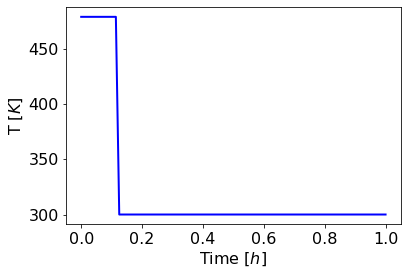

In [15]:
print('======Result summary======')
print('This optimization is solved with status:', optimize_result.status)
print('The result FIM is:', optimize_result.FIM)
print('Four design criteria log10() value:')
print('A-optimality:', np.log10(optimize_result.trace))
print('D-optimality:', np.log10(optimize_result.det))
print('E-optimality:', np.log10(optimize_result.min_eig))
print('Modified E-optimality:', np.log10(optimize_result.cond))

t_list = []
for t in optimize_result.model.t:
    t_list.append(t)

T_list = []
for i in t_list:
    T_list.append(pyo.value(optimize_result.model.T[i]))
    
si=16
plt.rc('axes', titlesize=si)
plt.rc('axes', labelsize=si)
plt.rc('xtick', labelsize=si)
plt.rc('ytick', labelsize=si)
plt.rc('legend', fontsize=12)
plt.plot(t_list, T_list, 'b', linewidth=2)
#plt.scatter(t_list, T_list, 'b')
plt.ylabel('T [$K$]')
plt.xlabel('Time [$h$]')
plt.show()

## Method: Exploratory analysis (Enumeration)

This method conducts exploratory analysis by enumeration. 
It allows a user to define any number (dimensions) of design variables.
Heatmaps can be drawn by two design variables, fixing other design variables; 
1D curve can be drawn by one design variable, fixing other design variables.

### Specify user inputs

In [ ]:
# Design variable ranges as lists 
design_ranges = [list(np.linspace(1,5,5)), list(np.linspace(300,700,5))]

# Design variable names 
dv_apply_name = ['CA0','T']

# Design variable should be fixed at these time points
dv_apply_time = [[0],t_control]

# Define experiments. This is a starting point of which the value does not matter
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])
    
## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [ ]:
# add prior information
prior_all = [[ 22.52943024 , 1.84034314, -70.23273336, -11.09432962],
 [   1.84034314 ,  18.09848116 ,  -5.73565034 , -109.15866135],
 [ -70.23273336 ,  -5.73565034 , 218.94192843 ,  34.57680848],
 [ -11.09432962 , -109.15866135 ,  34.57680848 ,  658.37644634]]

print(np.shape(prior_all))

prior_pass=np.asarray(prior_all)
print(np.shape(prior_pass))

print('The prior information FIM:', prior_pass)
print('Prior Det:', np.linalg.det(prior_pass))

In [ ]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

### 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

## draw 1D sensitivity curve 

fixed = {"'CA0'": 5.0}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )



## Heatmap

In [ ]:
fixed = {}
all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )

## Grid search for 3 design variables

In [ ]:
# Define design ranges
design_ranges = [list(np.linspace(1,5,2)),  list(np.linspace(300,700,2)), [300,500]]

# Define design variable 
# Here the two T are for different controlling time subsets
dv_apply_name = ['CA0', 'T', 'T']
dv_apply_time = [[0], [0], [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875,1]]

# Define experiments
exp1 = generate_exp(t_control, 5, [300, 300, 300, 300, 300, 300, 300, 300, 300])

## choose from 'sequential_finite', 'direct_kaug'
#sensi_opt = 'sequential_finite'
sensi_opt = 'direct_kaug'

# model option
if sensi_opt == 'direct_kaug':
    args_ = [False]
else:
    args_ = [True]

In [ ]:
doe_object = doe.DesignOfExperiments(parameter_dict, dv_pass,
                                 measure_class, createmod,
                                prior_FIM=prior_pass, discretize_model=disc, args=args_)

all_fim = doe_object.run_grid_search(exp1, design_ranges, dv_apply_name, dv_apply_time, 
                                     mode=sensi_opt)

### Draw 1D sensitivity curve

In [ ]:
test = all_fim.extract_criteria()

In [ ]:
## draw 1D sensitivity curve 

fixed = {"'CA0'": 1.0, "'T2'": 300}

all_fim.figure_drawing(fixed, ['T'], 'Reactor case','T [K]','$C_{A0}$ [M]' )

### Draw 2D sensitivity curve

In [ ]:
fixed = {"'T2'": 300}

all_fim.figure_drawing(fixed, ['CA0','T'], 'Reactor case','$C_{A0}$ [M]', 'T [K]' )